This shows how the set up was for one of the classifiers: kNN. First, you will see a classifier with a preprocessing of PCA. After this, we discovered that there was just too much variance in the outcome. Since tuning the kNN parameters did not give the more robust results we were searching for, we took a step back to the preprocessing. The choice was made to use the univariate feature selection. This, because it might give way to less features being selected and therefore hopefully a more robust result, or higher AUC. 

In [1]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif




In [2]:
# Preprocessing function of PCA

def data_preprocessing_PCA(X_train, X_validation):
    '''Data preprocessing PCA'''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Feature selection/extraction
    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca

In [3]:
# Preprocessing function of Univariate Analysis 

def data_preprocessing_Uni(X_train, y_train, X_test, y_test):
    '''Data preprocessing Univariate'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_test_scaled = scaler.transform(X_test)
    df_X_test_scaled = pd.DataFrame(X_test_scaled)
    
    # 2. Feature selection/extraction
    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(10,'Score'))  #print 10 best features
    best_features = featureScores.nlargest(10,'Score')['Specs']

    df_X_train_features = df_X_train_scaled[best_features]
    df_X_test_features = df_X_test_scaled[best_features]

    return df_X_train_features, df_X_test_features 


In [4]:
# Loading of data 
from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

# Split data in a train and test set

split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

The number of samples: 113
The number of features: 159


First, the example below will show the search for the proper kNN parameter of the amount of nearest neighbours. 

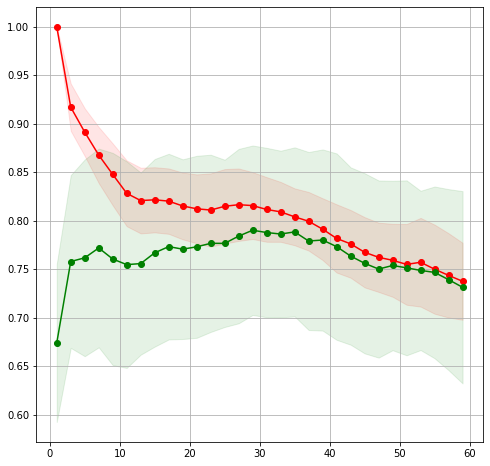

In [5]:
# AUROC of different values for K in kNN, on the validation-training set. 

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 60, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_PCA(X_train, X_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
            test_proba = clf_knn.predict_proba(X_validation_pca)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_test = metrics.roc_auc_score(y_validation, test_proba)
            

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")


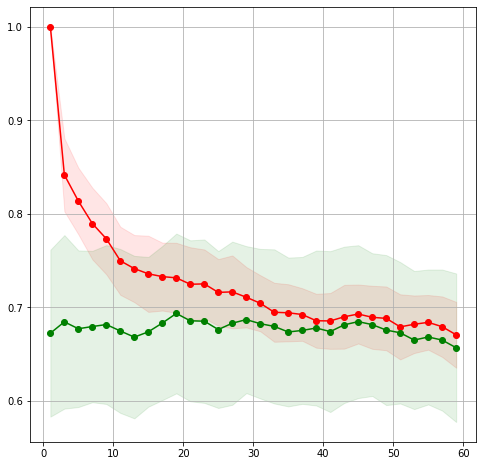

In [6]:
# Now, the kNN will be plotted for the scoring of the classifiers. 
k_list = list(range(1, 60, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing 
        X_train_pca, X_validation_pca = data_preprocessing_PCA(X_train, X_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)
            # Test the classifier on the training data and plot
       
            score_train = clf_knn.score(X_train_pca, y_train)
            score_test = clf_knn.score(X_validation_pca, y_validation)            

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")


The above graphics show the trend of the kNN, another method for obtaining the exact kNN that works best in a certain fold is through a GridSearch. This is done below. 

In [7]:

clf_knn = neighbors.KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {
    "n_neighbors": list(range(1, 50, 2))
}

cv_5fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
grid_search = model_selection.GridSearchCV(clf_knn, parameters, cv=cv_5fold, scoring='roc_auc')

result = []
for _ in range(20):
    # Preprocessing 
    X_train_pca, X_validation_pca = data_preprocessing_PCA(split_X_train, X_validation)
    grid_search.fit(X_train_pca, split_y_train)

    print(grid_search.best_params_)

{'n_neighbors': 27}
{'n_neighbors': 29}
{'n_neighbors': 7}
{'n_neighbors': 33}
{'n_neighbors': 29}
{'n_neighbors': 27}
{'n_neighbors': 33}
{'n_neighbors': 15}
{'n_neighbors': 33}
{'n_neighbors': 17}
{'n_neighbors': 29}
{'n_neighbors': 29}
{'n_neighbors': 31}
{'n_neighbors': 19}
{'n_neighbors': 29}
{'n_neighbors': 33}
{'n_neighbors': 17}
{'n_neighbors': 27}
{'n_neighbors': 7}
{'n_neighbors': 33}


There is quite some variance in the best kNN number.

In [17]:
clf_knn = neighbors.KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {
    "n_neighbors": list(range(1, 50, 2))
}
cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
grid_search = model_selection.GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

train_all = []
test_all = []

for _ in range(10):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]


        # Data preprocessing
        X_train_pca, X_test_pca = data_preprocessing_PCA(X_train, X_test)
        grid_search.fit(X_train_pca, y_train) 
        clf_knn = grid_search.best_estimator_

        # Tests 
        train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
        test_proba = clf_knn.predict_proba(X_test_pca)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)


[0.78392857]
[0.07837945]


This gives quite okay results if we want to achieve an AUC of 70%, however the standard deviation varies quite a lot. In addition to the already varying AUC. Therefore, we have to get back to our strategy. The hyperparameter is, partly, already tuned. Another big influence on the result is the way in which preprocessing was done. Therefore, we will now explore another method; Univariate. For the breviation, only the validation-train curve using AUROC is visualized in the below example. Hereafter, the direct hyperparameter tuning with GridSearchCV is used in the 'inner' loop and compared to the test set. 

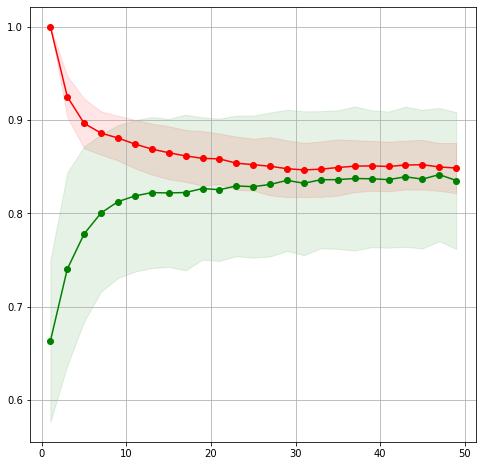

In [18]:
# AUROC of different values for K in kNN, on the validation-training set. 

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_Uni(X_train, y_train, X_validation, y_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
            test_proba = clf_knn.predict_proba(X_validation_pca)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_test = metrics.roc_auc_score(y_validation, test_proba)
            

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")


It shows a higher AUROC already in the graph, with a standard deviation above the 0.70. Now, lets have a look on how it performs on our test set with the hyperparameters chosen in the 'inner' loop.  

In [20]:

clf_knn = neighbors.KNeighborsClassifier()
# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {
    "n_neighbors": list(range(1, 50, 2))
}
cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
grid_search = model_selection.GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

train_all = []
test_all = []
for _ in range(4):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]


        # Data preprocessing
        df_X_train_features, df_X_test_features = data_preprocessing_Uni(X_train, y_train, X_test, y_test)


        # # Classifier with hyperparameter n = 35
        # clf_knn = neighbors.KNeighborsClassifier(n_neighbors=35)
        # clf_knn.fit(df_X_train_features, y_train)

        grid_search.fit(df_X_train_features, y_train) 
        clf_knn = grid_search.best_estimator_

        # Tests 
        train_proba = clf_knn.predict_proba(df_X_train_features)[:, 1]
        test_proba = clf_knn.predict_proba(df_X_test_features)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)

[0.89030612]
[0.04552696]
